### Imports

In [2]:
# Import required packages
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import fsolve
import warnings
from scipy.io import mmread
from scipy.io import loadmat
from statistics import mean

from scipy.stats import linregress
from scipy.optimize import curve_fit
import community 
import os
from scipy.io import loadmat
import community 

# Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")


Creating stochastic block model graph (p currently hard coded in function)

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def create_network(n, alpha_s):
    # Define the number of nodes in each block
    n_left = n // 2
    n_right = n - n_left
    
    # Define the block sizes and probabilities
    block_sizes = [n_left, n_right]
    p_in = alpha_s * (1/150)
    p_out = (2 - alpha_s) * (1/150)
    
    #print(block_sizes)
    #print(p_in)
    #print(p_out)
    
    # Create a stochastic block model graph
    #try:
    G = nx.stochastic_block_model(block_sizes, [[p_in, p_out], [p_out, p_in]])
    #except:
    #    G = nx.stochastic_block_model(block_sizes, [[2*(1/150), 0], [0, 2*(1/150)]])

    # Assign "left" or "right" attribute to nodes
    for i, node in enumerate(G):
        if i < n_left: 
            G.nodes[node]['wing'] = 'left'
        else:
            G.nodes[node]['wing'] = 'right'
            
    return G

### Utils

In [1]:
def misinfo_spread(G, pi_left, pi_right, mis_count_scale = 1, missing_count=True, info=True):

    # Make a copy so we don't effect original graph
    G_new = G.copy()
    
    # Determine whether nodes are active based on pi
    for node in G_new.nodes:
        if G_new.nodes[node]['wing'] == 'left':
            if random.random() < pi_left:
                G_new.nodes[node]['active'] = False
            else:
                G_new.nodes[node]['active'] = True
        elif G_new.nodes[node]['wing'] == 'right':
            if random.random() < pi_right:
                G_new.nodes[node]['active'] = False
            else:
                G_new.nodes[node]['active'] = True
                
    
    infected_nodes = set()
    t = 0
    mis_count = 0
    
    
    # Set all nodes as uninfected
    for node in G_new.nodes():
        G_new.nodes[node]['infected'] = False
    
    
    # Choose one node with wing='right' from the largest component to randomly to start the spread
    connected_components = list(nx.connected_components(G_new))
    largest_component = max(connected_components, key=len)
    # Adding try/except for max homophily case
    try:
        random_right_node = random.choice([node for node, attrs in G_new.nodes(data=True) if (node in largest_component) and (attrs['wing'] == 'right') and (attrs['active'] == True)])
    except:
        random_right_node = random.choice([node for node, attrs in G_new.nodes(data=True) if (attrs['wing'] == 'right') and (attrs['active'] == True)])
    infected_nodes.add(random_right_node)
    G_new.nodes[random_right_node]['infected'] = True
    
    
    # Iterate over time periods until no new person spreads fake news
    new_infections = set()
    new_infections.add(random_right_node)
    mis_count_nodes = set()
    
    while True:
        t += 1

        # Defining sets as new_infections cannot be updated during the loop
        nodes_to_remove = set()
        nodes_to_add = set()
        
        # Iterate over infected nodes and infect their neighbors if they are active
        for node in new_infections:
            # Remove node from infections so each node only has one chance to spread fake news
            nodes_to_remove.add(node)
            for neighbor in G_new.neighbors(node):
                if neighbor not in infected_nodes and neighbor not in new_infections:
                    if G_new.nodes[neighbor]['active'] == True:
                        if missing_count:
                            # Reduce infection probability based on proportion of missing count clicks
                            count_proportion = mis_count/len(G_new)
                            if random.random() > count_proportion * mis_count_scale:
                                G_new.nodes[neighbor]['infected'] = True
                                nodes_to_add.add(neighbor)
                            else:
                                # if neighbor not in mis_count_nodes: 
                                    mis_count += 1
                                    mis_count_nodes.add(neighbor)
                                    # After adding to missing count the node becomes inactive
                                    G_new.nodes[neighbor]['active'] = False
                        else:
                            G_new.nodes[neighbor]['infected'] = True
                            nodes_to_add.add(neighbor)
                           
                    else: 
                         # If neighbor is not active then they add to the missing count
                        if missing_count and neighbor not in mis_count_nodes:
                            mis_count += 1
                            mis_count_nodes.add(neighbor)
                            G_new.nodes[neighbor]['active'] = False
            
            # Update the list of infected nodes so one node is not counted twice
            infected_nodes.update(nodes_to_add)
            
        # Remove all nodes which have shared fake news (as only one shot to infect)                
        new_infections.difference_update(nodes_to_remove)
        new_infections.update(nodes_to_add)
                              
        if not new_infections:
            break
            
    
    if info:
        print("Simulation lasted " + str(t) + " periods")
        if missing_count:
            print("Missing count at end of simulation: " + str(mis_count))
            print("Missing count (proportion of network): " + str(mis_count/len(G_new)))
        print("Number of people sharing fake news: " + str(len(infected_nodes)))
        print("Proportion of people sharing fake news: " + str(len(infected_nodes)/len(G_new)))
        
    return G_new


# Function to calculate the reach of misinformation (as percentage)
def reach_calculator_percentage(G):
    nodes_reached = set()
    for node in G.nodes():
        # Check if the node has the specific attribute
        if G.nodes[node]['infected'] == True:
            neighbors = G.neighbors(node)
            nodes_reached.add(node)
            nodes_reached.update(neighbors)
            
    # Calculate reach as percentage of total nodes
    reach_percentage = len(nodes_reached) / len(G.nodes()) * 100
    return reach_percentage

# Function to calculate the reach of misinformation
def reach_calculator(G):
    nodes_reached = set()
    for node in G.nodes():
    # Check if the node has the specific attribute
        if G.nodes[node]['infected'] == True:
            neighbors = G.neighbors(node)
            nodes_reached.add(node)
            nodes_reached.update(neighbors)
            
    return len(nodes_reached)

# Function to calculate reach as they do in the Gong paper
def reach_calculator_paper(G):
    nodes_reached = set()
    for node in G.nodes():
        # Check if the node has the specific attribute 'infected' and 'active'
        if G.nodes[node]['infected'] == True:
            neighbors = G.neighbors(node)
            # Add only neighbors with the 'active' attribute set to True
            for neighbor in neighbors:
                if G.nodes[neighbor]['active'] == True:
                    nodes_reached.add(neighbor)
            
    return len(nodes_reached)

# Function to calculate the influence of misinformation (as percentage)
def influence_calculator_percentage(G):
    nodes_influenced = 0
    for node in G.nodes():
        if G.nodes[node]['wing'] == 'left' and G.nodes[node]['infected'] == True:
            nodes_influenced += 1
            
    # Calculate influence as percentage of total nodes
    influence_percentage = nodes_influenced / len(G.nodes()) * 100
    return influence_percentage

# Function to calculate the influence of misinformation
def influence_calculator(G):
    nodes_influenced = 0
    for node in G.nodes():
        if G.nodes[node]['wing'] == 'left' and G.nodes[node]['infected'] == True:
            nodes_influenced += 1
            
    return nodes_influenced

# For a given graph, sim the misinformation spread and calculate the difference in reach and influence, along with the base reach and influence.
def pol_effect(G, pi_left, pi_right, mis_count_scale):
    G_pol = misinfo_spread(G, pi_left, pi_right, mis_count_scale, missing_count=True, info=False)
    G_no_pol = misinfo_spread(G, pi_left, pi_right, mis_count_scale, missing_count=False, info=False)

    paper_reach = reach_calculator_paper(G_no_pol)
    reach = reach_calculator(G_no_pol)
    influence = influence_calculator(G_no_pol)
    paper_reach_diff = reach_calculator_paper(G_no_pol) - reach_calculator_paper(G_pol)
    reach_diff = reach_calculator(G_no_pol) - reach_calculator(G_pol)
    influence_diff = influence_calculator(G_no_pol) - influence_calculator(G_pol)

    return paper_reach, reach, influence, paper_reach_diff, reach_diff, influence_diff

# Function to plot different levels of alpha, finding the reach and influence without the policy, and then the effectivness of the policy
def vary_alpha(pi_left, pi_right, mis_count_scale=1):
    alpha_list = []
    paper_reach_list = []
    reach_list = []
    influence_list = []
    paper_reach_diff_list = []
    reach_diff_list = []
    influence_diff_list = []

    for alpha in np.arange(1, 2.05, 0.05):
        local_paper_reach_list = []
        local_reach_list = []
        local_influence_list = []
        local_paper_reach_diff_list = []
        local_reach_diff_list = []
        local_influence_diff_list = []
        # Generate graph 10 times for each alpha to average over
        for i in range(500):
            G = create_network(600, round(alpha, 2))

            # See reach, influence and effectiveness of policy
            paper_reach, reach, influence, paper_reach_diff, reach_diff, influence_diff = pol_effect(G, pi_left, pi_right, mis_count_scale)

            # Add to lists for plotting
            local_paper_reach_list.append(paper_reach)
            local_reach_list.append(reach)
            local_influence_list.append(influence)
            local_paper_reach_diff_list.append(paper_reach_diff)
            local_reach_diff_list.append(reach_diff)
            local_influence_diff_list.append(influence_diff)

        alpha_list.append(round(alpha, 2))
        paper_reach_list.append(mean(local_paper_reach_list))
        reach_list.append(mean(local_reach_list))
        influence_list.append(mean(local_influence_list))
        paper_reach_diff_list.append(mean(local_paper_reach_diff_list))
        reach_diff_list.append(mean(local_reach_diff_list))
        influence_diff_list.append(mean(local_influence_diff_list))

    return alpha_list, paper_reach_list, reach_list, influence_list, paper_reach_diff_list, reach_diff_list, influence_diff_list

# Function to plot two lists on the same graph with different scales
def plot_two_lines(alpha_list, list1, list2, title1: str, title2: str, degree=2):
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Level of homophily')
    ax1.set_ylabel(title1, color=color)
    ax1.plot(alpha_list, list1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:red'
    ax2.set_ylabel(title2, color=color)
    ax2.plot(alpha_list, list2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.grid(True)

    # Fit polynomial curves
    p1 = np.polyfit(alpha_list, list1, degree)
    trend_line1 = np.polyval(p1, alpha_list)
    ax1.plot(alpha_list, trend_line1, linestyle='--', color='blue')

    p2 = np.polyfit(alpha_list, list2, degree)
    trend_line2 = np.polyval(p2, alpha_list)
    ax2.plot(alpha_list, trend_line2, linestyle='--', color='red')

    plt.show()
    
# Function to plot one of the measures over different values of pi
def plot_pi_trends(alpha_list, pi_dict, y_label, degree=2):
    fig, ax = plt.subplots()

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (key, list) in enumerate(pi_dict.items()):
        p = np.polyfit(alpha_list, list, degree)
        trend_line = np.polyval(p, alpha_list)
        ax.plot(alpha_list, trend_line, linestyle='--', color=colors[i], label=f'pi[1] = {key}')

    ax.set_xlabel('Level of homophily')
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.legend()
    plt.show()

def community_detection(data):
    # Extract relevant information from the dictionary
    adjacency_matrix = data['A']

    # Create a graph using networkx
    G = nx.Graph(adjacency_matrix)

    # Initialize partition with two communities
    partition = {node: 0 if node < G.number_of_nodes() // 2 else 1 for node in G.nodes()}

    # Perform community detection using Louvain method, with the initialized partition
    partition = community.best_partition(G, partition=partition)

    # Convert partition to a dictionary for easier processing
    partition_dict = {node: comm_id for node, comm_id in partition.items()}
    # print("partition:", partition_dict)

    # Combine nodes into two communities
    communities = {}
    for node, comm_id in partition_dict.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)
    
    # Assign "wing" attribute to each node based on their community membership
    for node in G.nodes():
        if partition_dict[node] == 0:
            G.nodes[node]['wing'] = 'right'
        else:
            G.nodes[node]['wing'] = 'left'
    return G, partition

def compute_homophily(G):
    # Perform community detection using Louvain method
    partition = community.best_partition(G)

    # Create a copy of the graph with community membership as node attributes
    G_copy = G.copy()
    nx.set_node_attributes(G_copy, partition, 'community')

    # Count the number of edges within communities and between communities
    intra_community_edges = 0
    inter_community_edges = 0

    for u, v in G_copy.edges():
        if G_copy.nodes[u]['community'] == G_copy.nodes[v]['community']:
            intra_community_edges += 1
        else:
            inter_community_edges += 1

    # Calculate homophily
    homophily = intra_community_edges / (intra_community_edges + inter_community_edges)
    # print("Homophily based on edges in the network:", homophily)
    return homophily

When building the above function/graph below, the average degree will be determined by p and n. The average degree will be p * n, and so the average number of edges will be half of this.

Number of nodes in the network: 600
Number of edges in the network: 1130


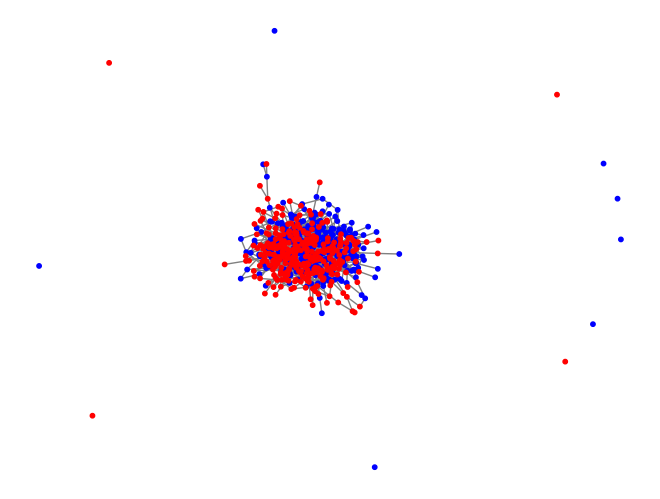

In [2]:
n = 600  # Number of nodes

# Between 1 and 2
alpha_s = 1.5
G = create_network(n, alpha_s)

print("Number of nodes in the network:", G.number_of_nodes())
print("Number of edges in the network:", G.number_of_edges())

# Convert 'wing' attribute values to colors
node_colors_G = ['blue' if G.nodes[node]['wing'] == 'left' else 'red' for node in G.nodes()]

# Plot the graph with colors based on the "wing" attribute
nx.draw(G, node_color=node_colors_G, node_size=10, edge_color='gray')

As explained in the paper, we use a base left pi of 0.9, while base right pi is 0.4. Below we plot the graphs measuring misinformation and the policy over different values of alpha.

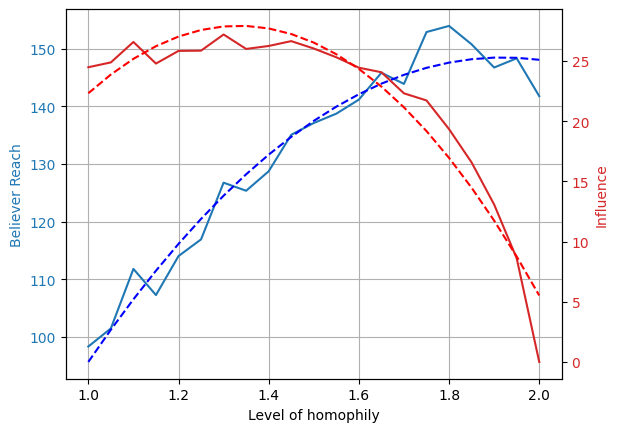

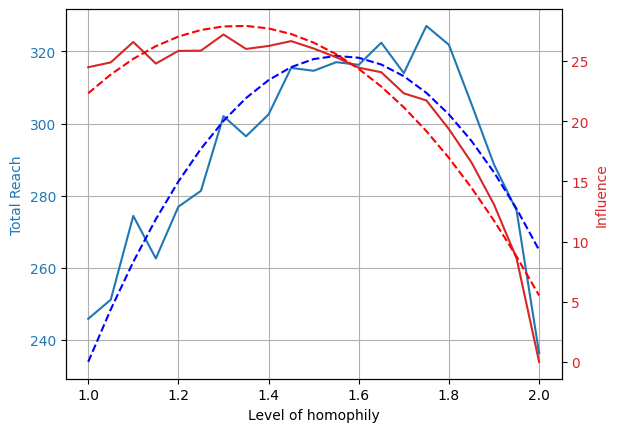

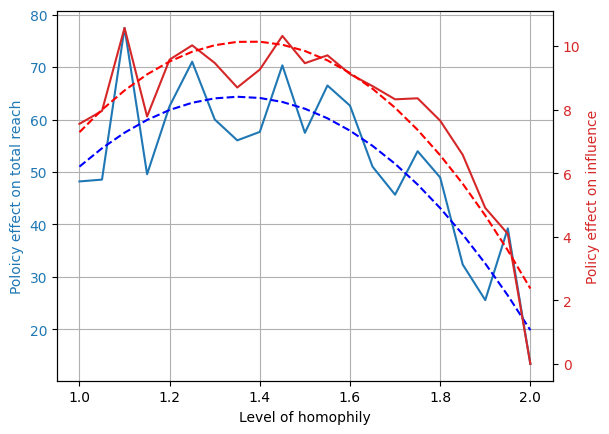

In [12]:
pi_left = 0.8
pi_right = 0.4

# Run simulations
alpha_list, paper_reach_list, reach_list, influence_list, paper_reach_diff_list, reach_diff_list, influence_diff_list = vary_alpha(pi_left, pi_right)

# Plot believer reach and influence
plot_two_lines(alpha_list, paper_reach_list, influence_list, "Believer Reach", "Influence")

# Plot total reach and influence
plot_two_lines(alpha_list, reach_list, influence_list, "Total Reach", "Influence")

# Plot pol effect on total reach and influence
plot_two_lines(alpha_list, reach_diff_list, influence_diff_list, "Poloicy effect on total reach", "Policy effect on influence")

As a robustness check we plot various different results below varying the right pi

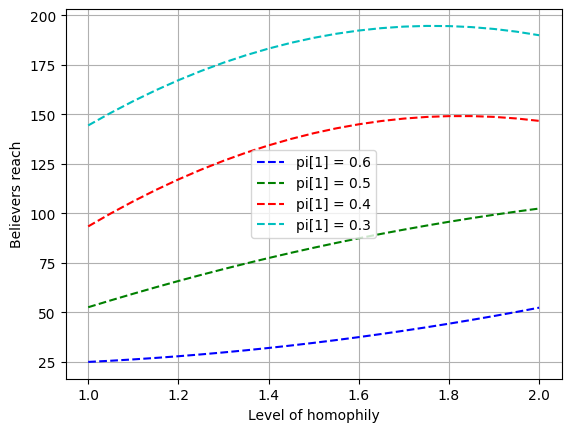

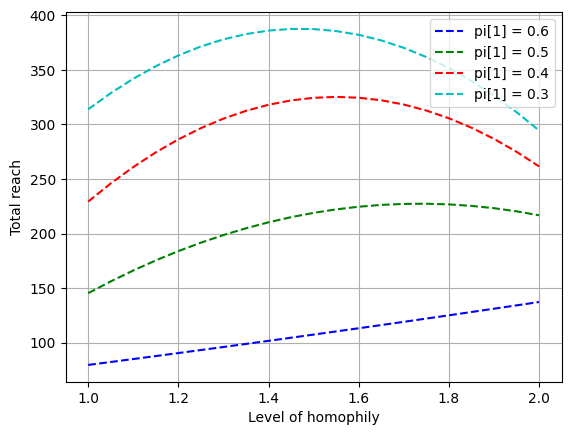

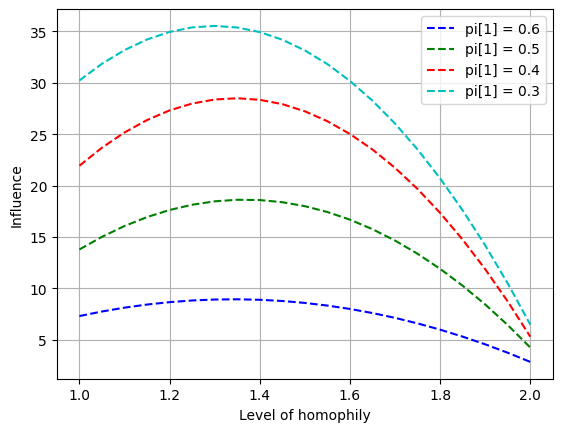

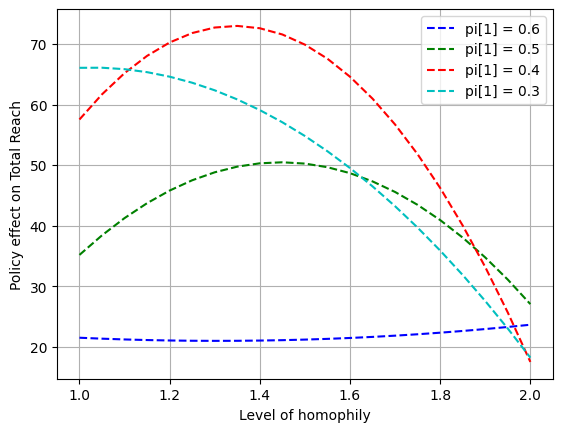

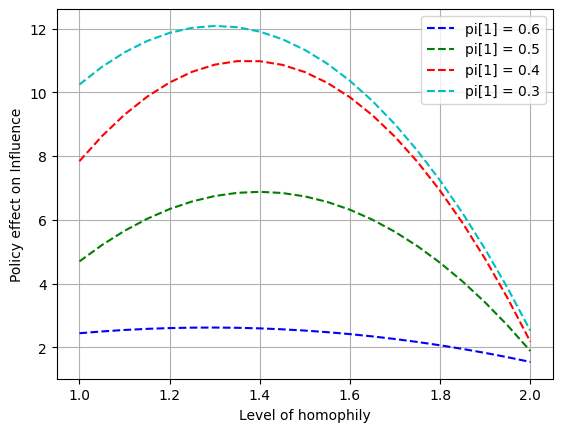

In [13]:
# Results for believers reach

pi_try = [[0.8, 0.6], [0.8, 0.5], [0.8, 0.4], [0.8, 0.3]]

pi_paper_reach_dict = {}
pi_reach_dict = {}
pi_influence_dict = {}
pi_reach_diff_dict = {}
pi_influence_diff_dict = {}

for pi in pi_try:
    alpha_list, paper_reach_list, reach_list, influence_list, paper_reach_diff_list, reach_diff_list, influence_diff_list = vary_alpha(pi[0], pi[1])
    pi_paper_reach_dict[pi[1]] = paper_reach_list
    pi_reach_dict[pi[1]] = reach_list
    pi_influence_dict[pi[1]] = influence_list
    pi_reach_diff_dict[pi[1]] = reach_diff_list
    pi_influence_diff_dict[pi[1]] = influence_diff_list

# Add this at the end of your loop
plot_pi_trends(alpha_list, pi_paper_reach_dict, 'Believers reach')
plot_pi_trends(alpha_list, pi_reach_dict, 'Total reach')
plot_pi_trends(alpha_list, pi_influence_dict, 'Influence')
plot_pi_trends(alpha_list, pi_reach_diff_dict, 'Policy effect on Total Reach')
plot_pi_trends(alpha_list, pi_influence_diff_dict, 'Policy effect on Influence')

## Real Data Application

In [3]:
# Read the MAT file
data = loadmat("./facebook100/USFCA72.mat")

G, partition = community_detection(data)
homophily = compute_homophily(G)
n = len(G)
# Simulate misinfo spread
G_sim = misinfo_spread(G, 0.8, 0.4, missing_count=False)
reach = reach_calculator_percentage(G_sim)
# reach = round((reach/n*100),2)
influence = influence_calculator_percentage(G_sim)
# influence = round((influence/n*100),2)

print(f'\nHomophily in the network: {round(homophily, 2)}\n')
print(f'Reached people by fake news: {reach}%')
print(f'Influenced people by fake news: {influence}%')

Simulation lasted 6 periods
Number of people sharing fake news: 877
Proportion of people sharing fake news: 0.3269947800149142

Homophily in the network: 0.6

Reached people by fake news: 93.84787472035794%
Influenced people by fake news: 11.968680089485458%


In [4]:
# Read the MAT file
data = loadmat("./facebook100/USFCA72.mat")

G, partition = community_detection(data)
homophily = compute_homophily(G)
n = len(G)
# Simulate misinfo spread
G_sim = misinfo_spread(G, 0.8, 0.4, missing_count=False)
reach = reach_calculator_percentage(G_sim)
# reach = round((reach/n*100),2)
influence = influence_calculator_percentage(G_sim)
# influence = round((influence/n*100),2)

print(f'\nHomophily in the network: {round(homophily, 2)}\n')
print(f'Reached people by fake news: {reach}%')
print(f'Influenced people by fake news: {influence}%')

Simulation lasted 7 periods
Number of people sharing fake news: 987
Proportion of people sharing fake news: 0.3680089485458613

Homophily in the network: 0.61

Reached people by fake news: 94.1461595824012%
Influenced people by fake news: 8.501118568232663%


In [6]:
# Simulate misinfo spread with mitigation policy
G_sim_policy = misinfo_spread(G, 0.8, 0.4, missing_count=True)
reach_policy = reach_calculator_percentage(G_sim_policy)
# reach_policy = round((reach_policy/n*100),2)
influence_policy = influence_calculator_percentage(G_sim_policy)/n*100
# influence_policy = round((influence_policy),2)

print(f'Reached people by fake news: {reach_policy}%')
print(f'Influenced people by fake news: {influence_policy}%')
print(f'\nDifference in reach with and without the policy {reach-reach_policy} percentage points')
print(f'\nDifference in influence with and without the policy {influence-influence_policy} percentage points')

Simulation lasted 6 periods
Missing count at end of simulation: 1740
Missing count (proportion of network): 0.6487695749440716
Number of people sharing fake news: 735
Proportion of people sharing fake news: 0.2740492170022371
Reached people by fake news: 92.28187919463086%
Influenced people by fake news: 0.180728150939703%

Difference in reach with and without the policy 1.8642803877703358 percentage points

Difference in influence with and without the policy 8.320390417292959 percentage points


In [8]:
# Directory containing the graph files
graph_directory = "./facebook100/"

# Lists to store computed metrics
homophily_values = []
reach_values = []
influence_values = []
reach_diff_values = []
influence_diff_values = []

# Iterate over each file in the directory
for file_name in os.listdir(graph_directory):
    if file_name.endswith(".mat"):
        # Read the MAT file
        data = loadmat(os.path.join(graph_directory, file_name))
        
        # Perform community detection and compute homophily
        G, partition = community_detection(data)
        homophily = compute_homophily(G)
        homophily_values.append(homophily)
        
        # Simulate misinfo spread without mitigation policy
        G_sim = misinfo_spread(G, 0.8, 0.4, missing_count=False)
        reach = reach_calculator_percentage(G_sim)
        influence = influence_calculator_percentage(G_sim)
        reach_values.append(reach)
        influence_values.append(influence)
        
        # Simulate misinfo spread with mitigation policy
        G_sim_policy = misinfo_spread(G, 0.8, 0.4, missing_count=True)
        influence_policy = influence_calculator_percentage(G_sim_policy) 
        reach_policy = reach_calculator_percentage(G_sim_policy)
        
        # Calculate reach and influence differences
        reach_diff = reach - reach_policy
        influence_diff = influence - influence_policy 
        
        reach_diff_values.append(reach_diff)
        influence_diff_values.append(influence_diff)
        print(file_name, reach_diff)




Simulation lasted 8 periods
Number of people sharing fake news: 2451
Proportion of people sharing fake news: 0.38059006211180124
Simulation lasted 6 periods
Missing count at end of simulation: 4138
Missing count (proportion of network): 0.6425465838509317
Number of people sharing fake news: 1830
Proportion of people sharing fake news: 0.2841614906832298
MIT8.mat 1.7546583850931654
Simulation lasted 7 periods
Number of people sharing fake news: 944
Proportion of people sharing fake news: 0.35197613721103654
Simulation lasted 6 periods
Missing count at end of simulation: 1820
Missing count (proportion of network): 0.6785980611483967
Number of people sharing fake news: 647
Proportion of people sharing fake news: 0.2412378821774795
USFCA72.mat 2.9455630126770984
Simulation lasted 7 periods
Number of people sharing fake news: 2623
Proportion of people sharing fake news: 0.3979669245941435
Simulation lasted 6 periods
Missing count at end of simulation: 4260
Missing count (proportion of netwo

### Mean differences in influence


In [9]:
print(f'Mean difference in influence: {np.mean(influence_diff_values)}')

Mean difference in influence: 3.822742400777051


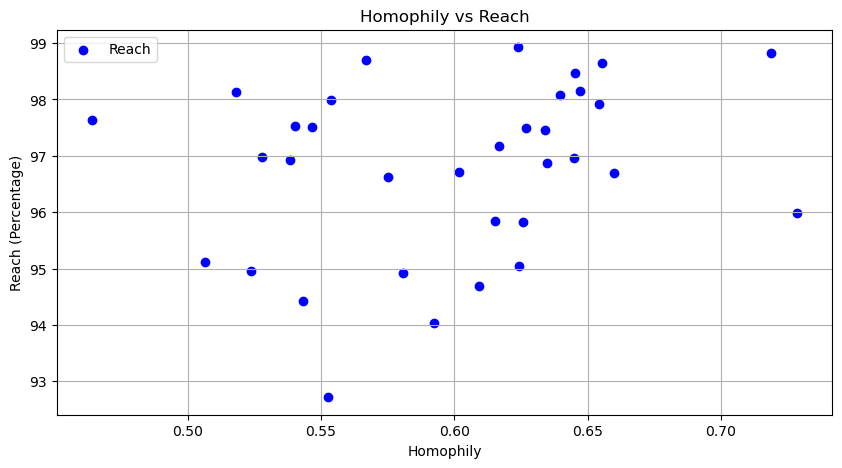

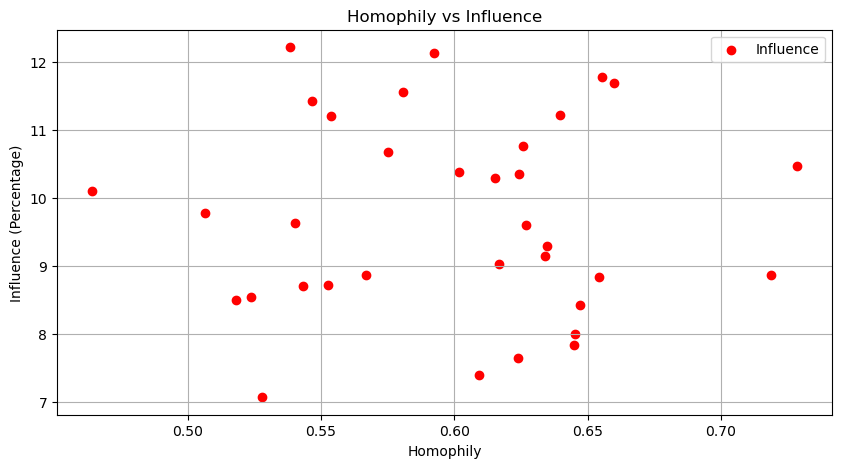

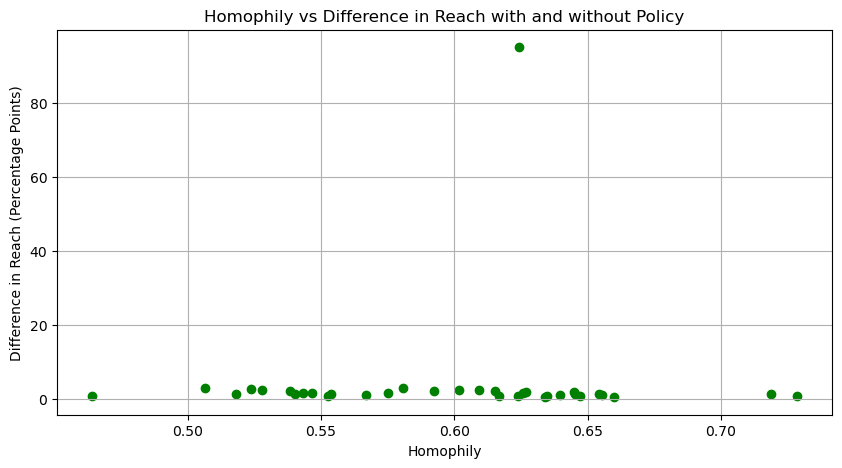

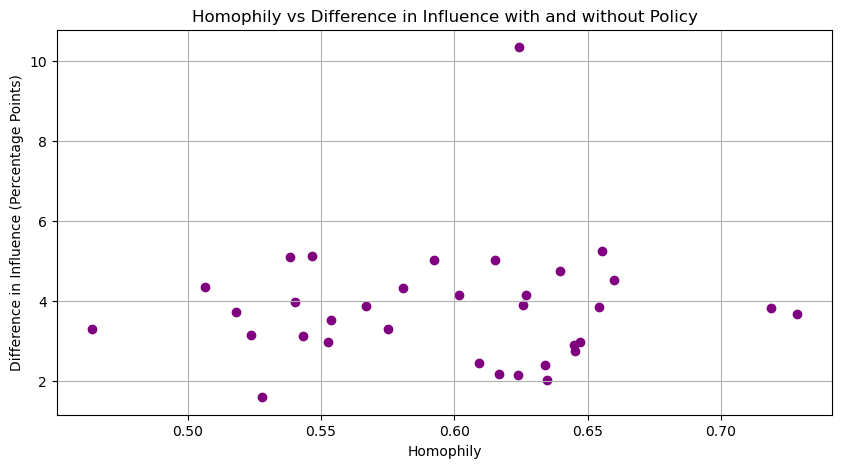

In [10]:
# Plotting homophily vs reach
plt.figure(figsize=(10, 5))
plt.scatter(homophily_values, reach_values, label='Reach', color='blue')
plt.xlabel('Homophily')
plt.ylabel('Reach (Percentage)')
plt.title('Homophily vs Reach')
plt.legend()
plt.grid(True)
plt.show()

# Plotting homophily vs influence
plt.figure(figsize=(10, 5))
plt.scatter(homophily_values, influence_values, label='Influence', color='red')
plt.xlabel('Homophily')
plt.ylabel('Influence (Percentage)')
plt.title('Homophily vs Influence')
plt.legend()
plt.grid(True)
plt.show()

# Plotting homophily vs difference in reach with and without the policy
plt.figure(figsize=(10, 5))
plt.scatter(homophily_values, reach_diff_values, color='green')
plt.xlabel('Homophily')
plt.ylabel('Difference in Reach (Percentage Points)')
plt.title('Homophily vs Difference in Reach with and without Policy')
plt.grid(True)
plt.show()

# Plotting homophily vs difference in influence with and without the policy
plt.figure(figsize=(10, 5))
plt.scatter(homophily_values, influence_diff_values, color='purple')
plt.xlabel('Homophily')
plt.ylabel('Difference in Influence (Percentage Points)')
plt.title('Homophily vs Difference in Influence with and without Policy')
plt.grid(True)
plt.show()